### IS4242 Group 8 Project

### Exploratory Data Analysis

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

In [128]:
# Constants

TARGET_VARS = ["hate", "privacy", "sexual",
               "impersonation", "illegal", "advertisement", "ai"]
RANDOM_STATE = 42

### Exploring the processed dataset

In [129]:
df = pd.read_csv('data/df_combined_processed_no_reddit_title_2023-03-30.csv')
df

,body,hate,privacy,sexual,impersonation,illegal,advertisement,ai
0,kalleron design refus collect recycl site hear...,0,0,0,0,0,0,0
1,hotmeringue2880 hi econom graduat year experi ...,0,0,0,0,0,0,0
2,milenakowalska hey year finish bachelor degre ...,0,0,0,0,0,0,0
3,rstonerphd studi make employe want leav job im...,0,0,0,0,0,1,0
4,temporarysection50 hi accept job offer earlier...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
41198,you muthafin lie 8220lifeask 20pearl coreyeman...,1,0,0,0,0,0,0
41199,youv gone broke wrong heart babi drove redneck...,0,0,0,0,0,0,0
41200,young buck wanna eat dat nigguh like aint fuck...,1,0,0,0,0,0,0
41201,youu got wild bitch tellin lie,1,0,0,0,0,0,0


### Target Class Exploration

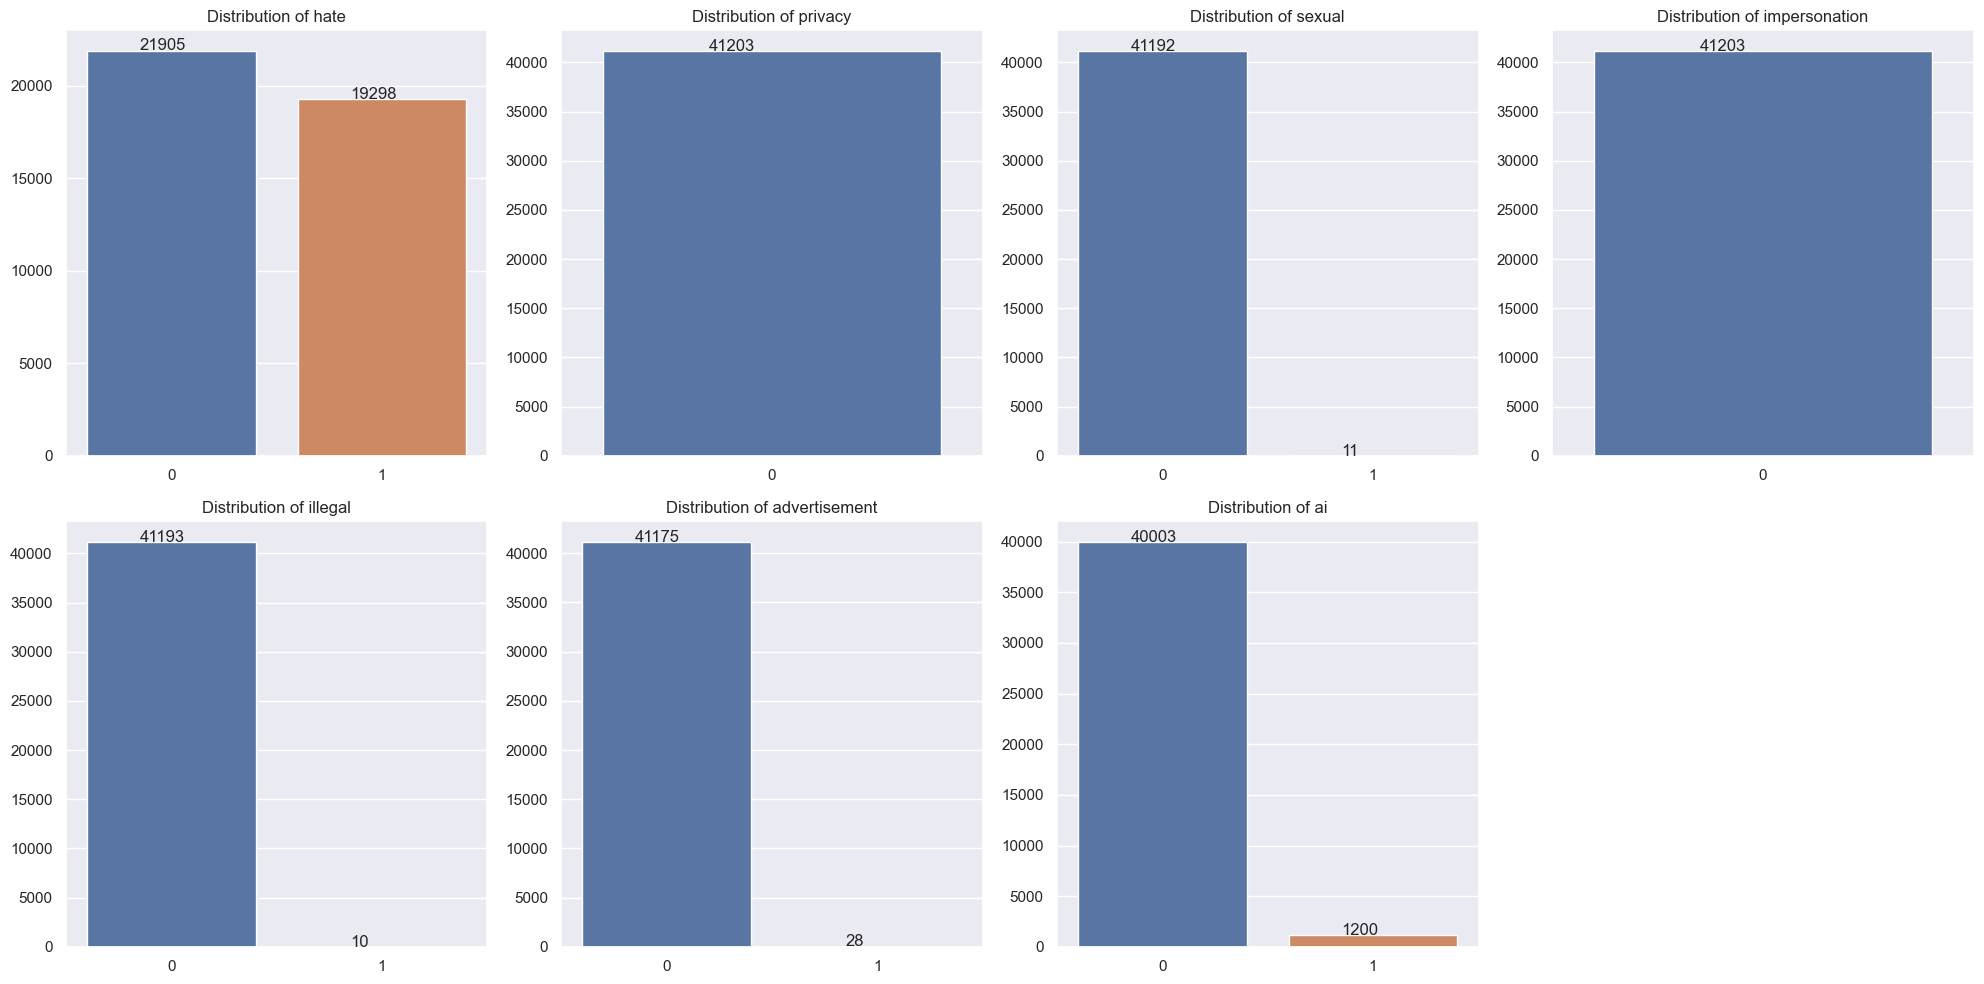

In [130]:
# Plotting the distribution of the target variables

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    if i < 7:
        sns.countplot(data=df, x=TARGET_VARS[i], ax=ax)
        ax.set_title(f'Distribution of {TARGET_VARS[i]}')
        ax.set_xlabel('')
        ax.set_ylabel('')
        # add counts to the bars
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',
                        (p.get_x()+0.25, p.get_height()+13))

    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Textual Exploration

#### N-Gram Analysis

In [131]:
# Calculating frequencies of n-grams

def n_gram_frequencies(text, n):

    # Splitting text into words
    words = str(text).split()

    # Creating n-grams
    n_grams = zip(*[words[i:] for i in range(n)])

    # Calculating frequencies
    n_gram_freq = {}
    for n_gram in n_grams:
        n_gram = " ".join(n_gram)
        if n_gram in n_gram_freq:
            n_gram_freq[n_gram] += 1
        else:
            n_gram_freq[n_gram] = 1

    return n_gram_freq


def combine_n_gram_dicts_row_wise(n_gram_dict, combined_dict):
    for key, value in n_gram_dict.items():
        if key in combined_dict:
            combined_dict[key] += value
        else:
            combined_dict[key] = value
    return n_gram_dict


def generate_n_gram_dicts(df):
    all_data_1_gram = {}
    all_data_2_gram = {}
    all_data_3_gram = {}
    df["n-grams_1"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_1_gram))
    df["n-grams_2"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_2_gram))
    df["n-grams_3"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_3_gram))
    return all_data_1_gram, all_data_2_gram, all_data_3_gram


def convert_dict_to_df(word_frequencies, min_freq=1):
    word_frequencies_df = pd.DataFrame.from_dict(
        word_frequencies, orient='index', columns=['Frequency'])
    word_frequencies_df = word_frequencies_df.sort_values(
        by='Frequency', ascending=False)
    word_frequencies_df = word_frequencies_df.reset_index().rename(columns={
        'index': 'Word'})
    word_frequencies_df = word_frequencies_df[word_frequencies_df['Frequency'] >= min_freq]
    return word_frequencies_df


def generate_wordcloud_from_freq(word_frequencies, var):
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=word_frequencies)
    # Display the generated image:
    fig, ax = plt.subplots(figsize=(16, 20))
    ax.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Word Cloud for {var}", fontsize=20)
    plt.show()


def generate_n_gram_analysis(df):
    for i in range(1, 4):
        df[f"n-grams_{i}"] = df["body"].apply(
            lambda x: n_gram_frequencies(x, i))

    # all data
    print("All Data")
    all_data_1_gram, all_data_2_gram, all_data_3_gram = generate_n_gram_dicts(
        df)
    print("All Data - 1-gram")
    display(convert_dict_to_df(all_data_1_gram).head(15))
    generate_wordcloud_from_freq(all_data_1_gram, "All Data - 1-gram")
    print("All Data - 2-gram")
    display(convert_dict_to_df(all_data_2_gram).head(15))
    generate_wordcloud_from_freq(all_data_2_gram, "All Data - 2-gram")
    print("All Data - 3-gram")
    display(convert_dict_to_df(all_data_3_gram).head(15))
    generate_wordcloud_from_freq(all_data_3_gram, "All Data - 3-gram")

    for var in TARGET_VARS:

        var_df = df[df[var] == 1]
        print(f"{var} data")
        var_1_gram, var_2_gram, var_3_gram = generate_n_gram_dicts(var_df)
        if var_1_gram:
            print(f"{var} data - 1-gram")
            display(convert_dict_to_df(var_1_gram).head(15))
            generate_wordcloud_from_freq(var_1_gram, f"{var} data - 1-gram")
        else:
            print(f"No 1-gram data for {var}. \n")

        if var_2_gram:
            print(f"{var} data - 2-gram")
            display(convert_dict_to_df(var_2_gram).head(15))
            generate_wordcloud_from_freq(var_2_gram, f"{var} data - 2-gram")
        else:
            print(f"No 2-gram data for {var}. \n")

        if var_3_gram:
            print(f"{var} data - 3-gram")
            display(convert_dict_to_df(var_3_gram).head(15))
            generate_wordcloud_from_freq(var_3_gram, f"{var} data - 3-gram")
        else:
            print(f"No 3-gram data for {var}. \n")

        print("=================================================================================================")

All Data
All Data - 1-gram


,Word,Frequency
0,bitch,11199
1,rt,7590
2,like,6248
3,get,4374
4,hoe,4206
5,im,3701
6,go,2990
7,dont,2968
8,one,2855
9,fuck,2775


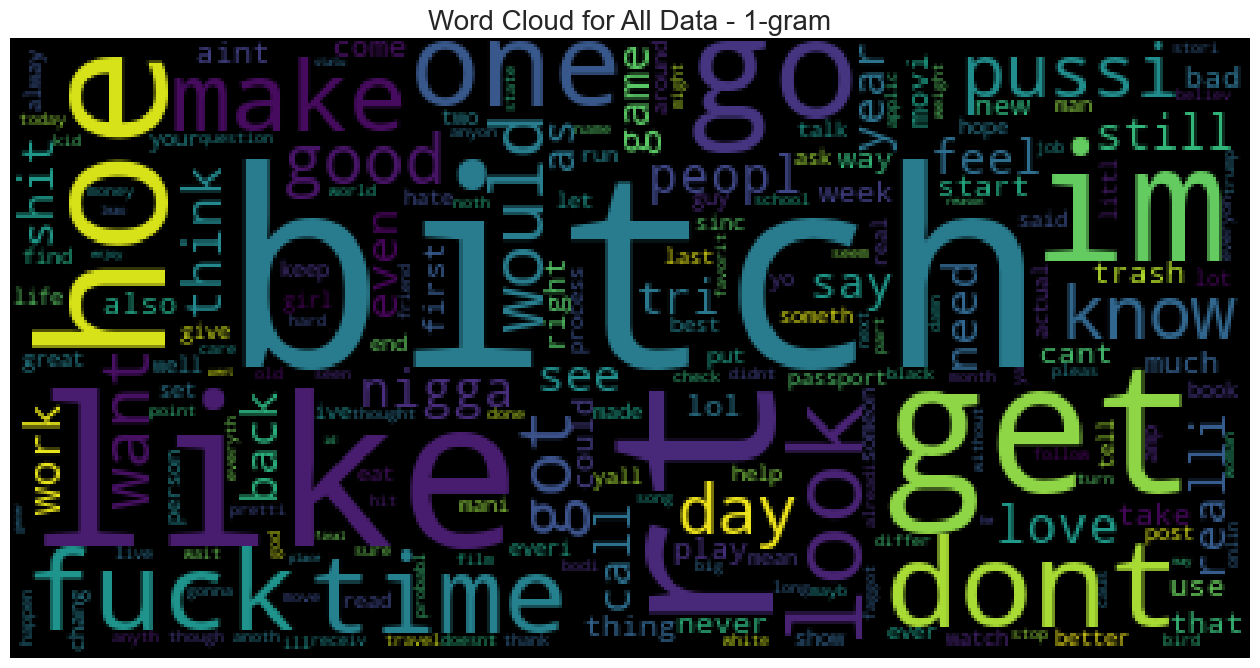

All Data - 2-gram


,Word,Frequency
0,look like,561
1,feel like,464
2,bad bitch,317
3,fuck bitch,255
4,like bitch,248
5,as bitch,245
6,dont know,244
7,bitch as,239
8,yo bitch,190
9,bitch dont,189


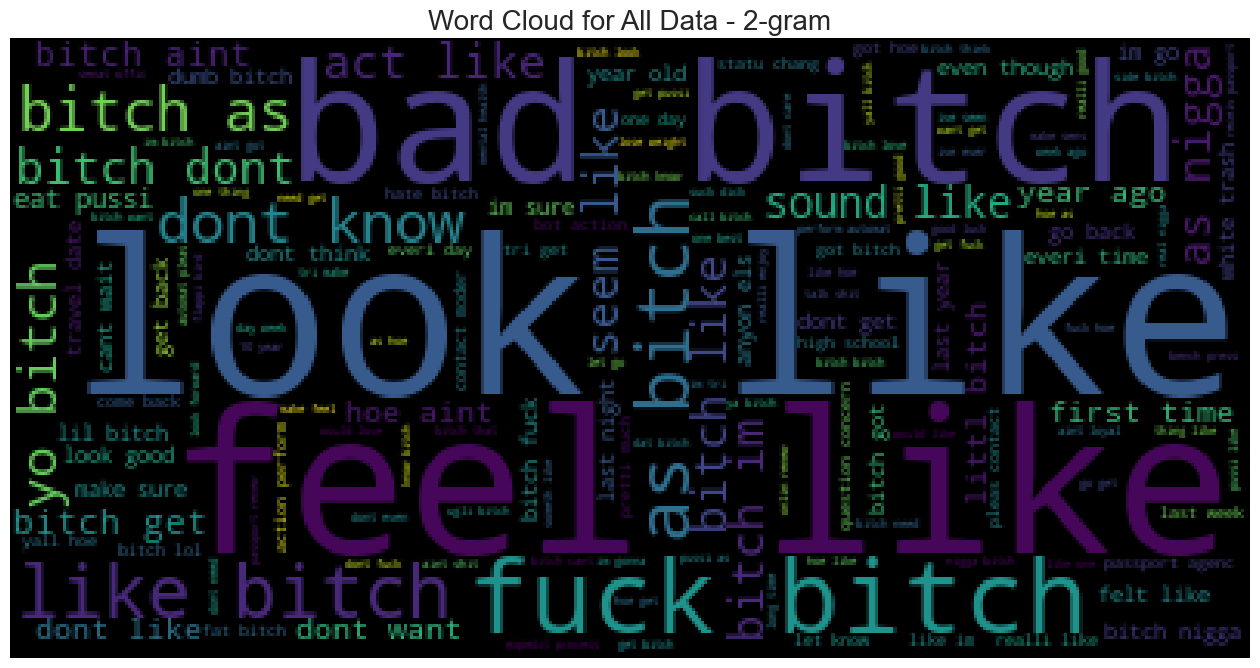

All Data - 3-gram


,Word,Frequency
0,perform automat pleas,81
1,automat pleas contact,81
2,pleas contact moder,81
3,action perform automat,81
4,bot action perform,81
5,hoe aint loyal,65
6,bitch as nigga,64
7,set 1015 rep,48
8,pleas report question,47
9,outlet post subreddit,47


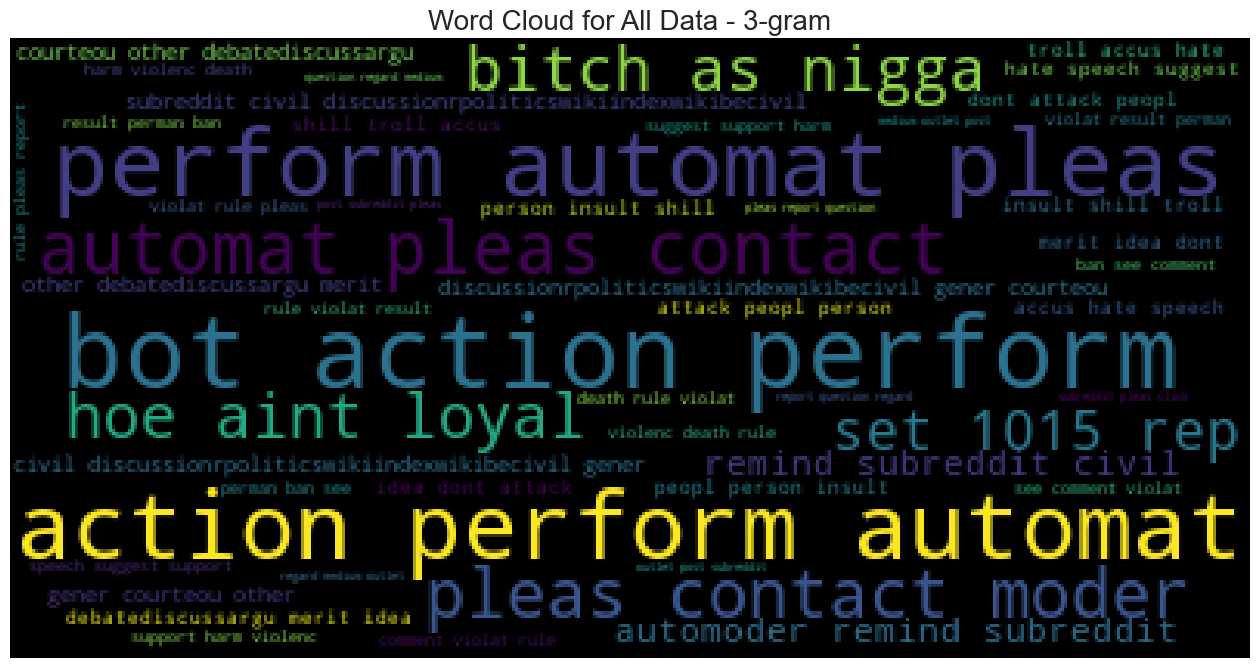

hate data
hate data - 1-gram


,Word,Frequency
0,bitch,10909
1,rt,5949
2,hoe,4064
3,like,2370
4,pussi,2122
5,fuck,2086
6,nigga,1764
7,im,1753
8,get,1499
9,dont,1493


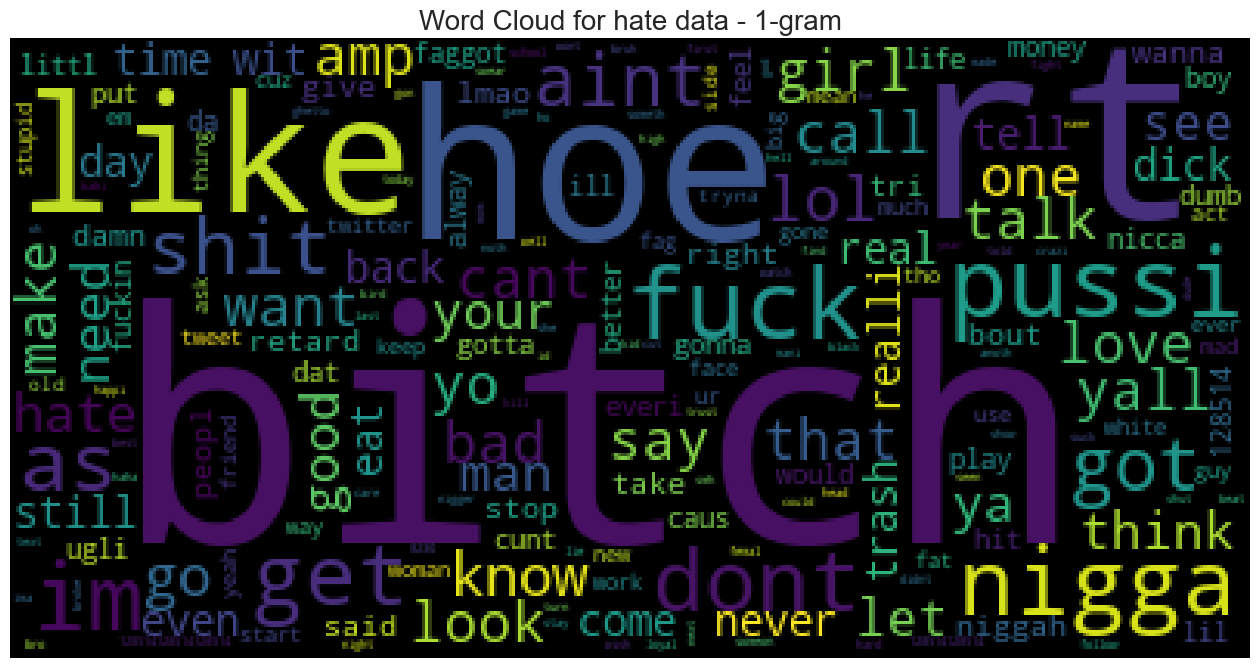

hate data - 2-gram


,Word,Frequency
0,bad bitch,315
1,fuck bitch,245
2,like bitch,239
3,as bitch,236
4,bitch as,225
5,look like,223
6,yo bitch,186
7,bitch dont,182
8,bitch like,177
9,bitch im,158


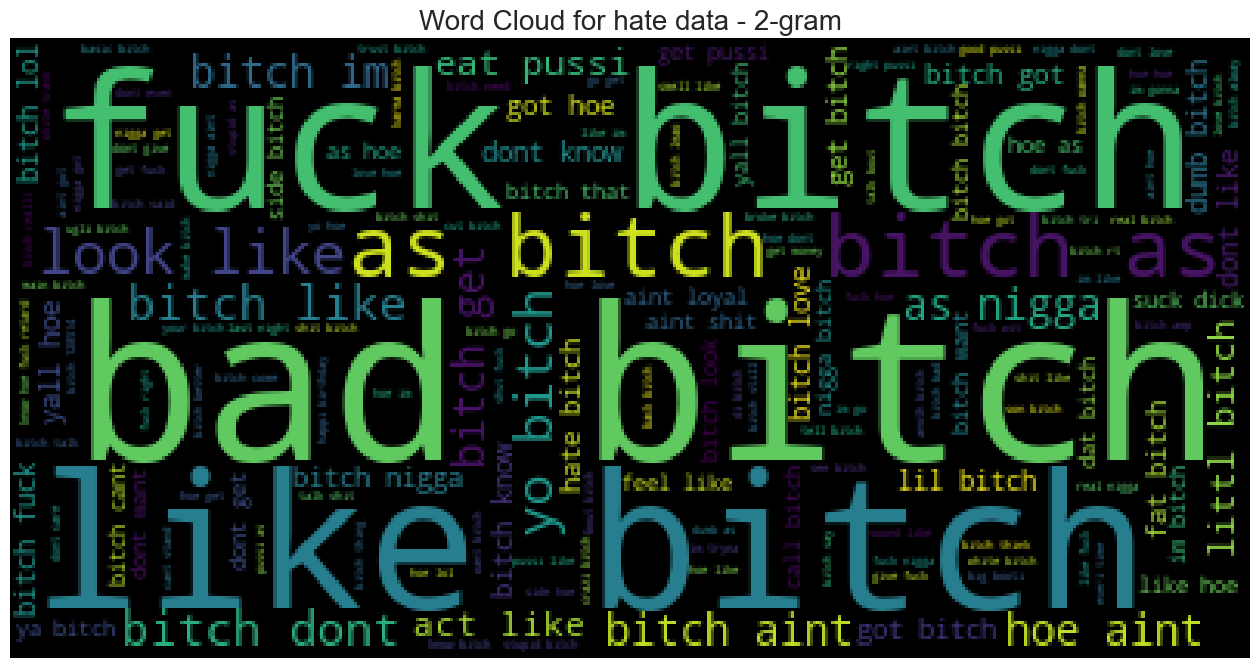

hate data - 3-gram


,Word,Frequency
0,hoe aint loyal,65
1,bitch as nigga,55
2,bitch look like,36
3,dont love hoe,32
4,hoe as nigga,26
5,fuck right pussi,25
6,stupid as bitch,24
7,act like bitch,23
8,yo bitch as,22
9,bitch thing like,21


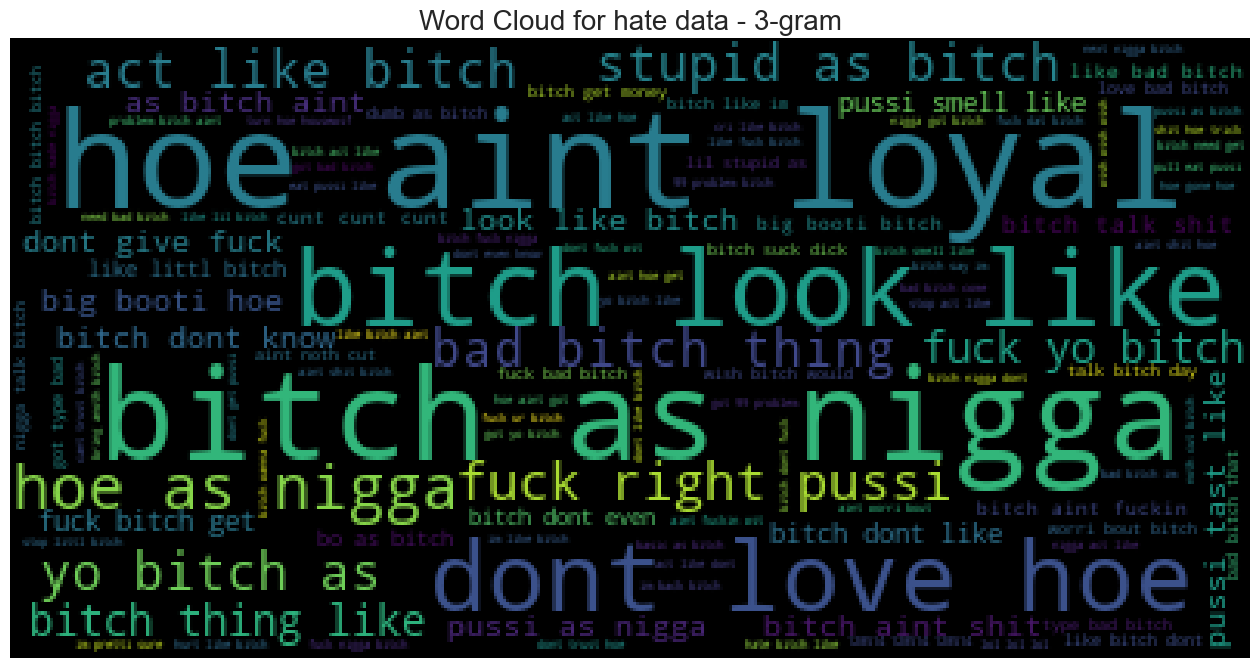

privacy data
No 1-gram data for privacy. 

No 2-gram data for privacy. 

No 3-gram data for privacy. 

sexual data
sexual data - 1-gram


,Word,Frequency
0,good,8
1,stori,7
2,new,6
3,sex,6
4,romanc,6
5,adult,6
6,feel,5
7,book,5
8,lot,5
9,find,4


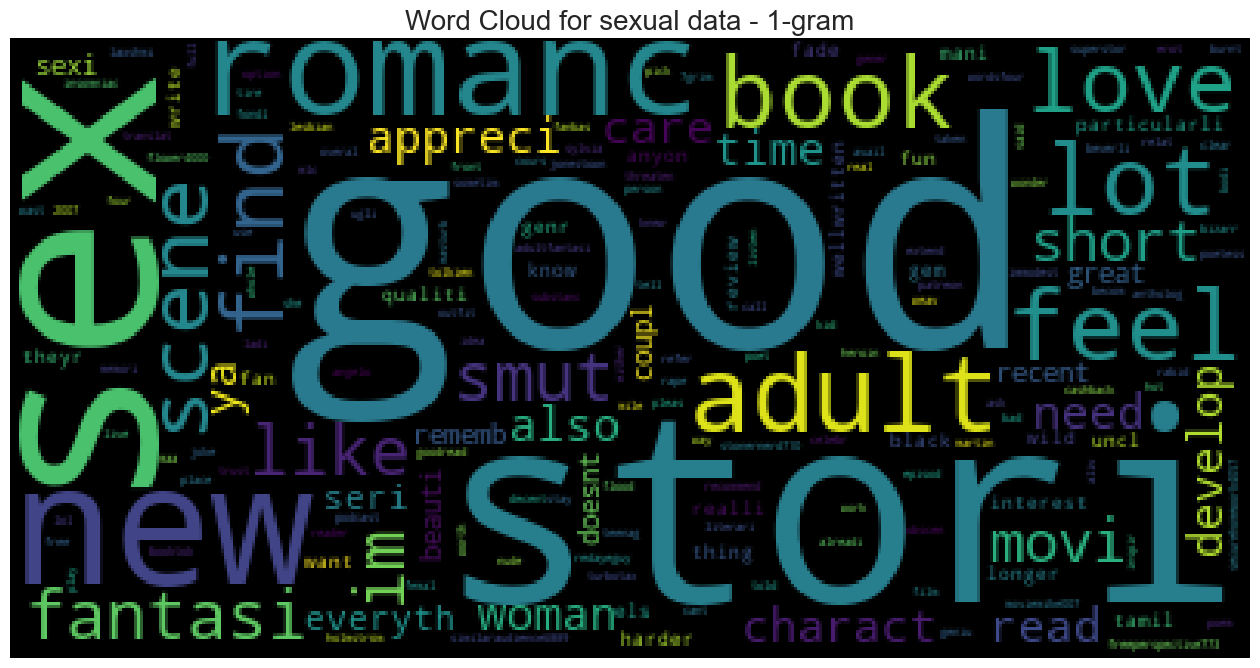

sexual data - 2-gram


,Word,Frequency
0,new adult,4
1,feel like,3
2,good stori,3
3,fade black,2
4,anyon els,2
5,els feel,2
6,appreci good,2
7,like ya,2
8,ya sex,2
9,woman appreci,2


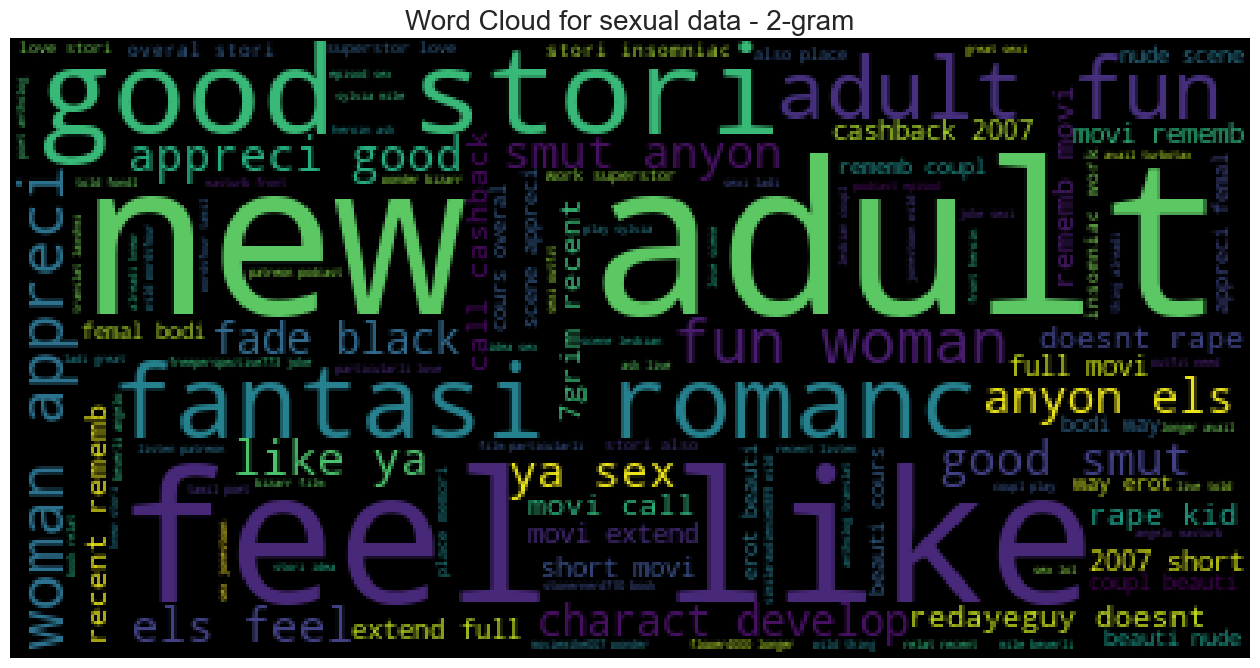

sexual data - 3-gram


,Word,Frequency
0,fun woman appreci,2
1,like ya sex,2
2,feel like ya,2
3,els feel like,2
4,anyon els feel,2
5,smut anyon els,2
6,good smut anyon,2
7,appreci good smut,2
8,woman appreci good,2
9,adult fun woman,2


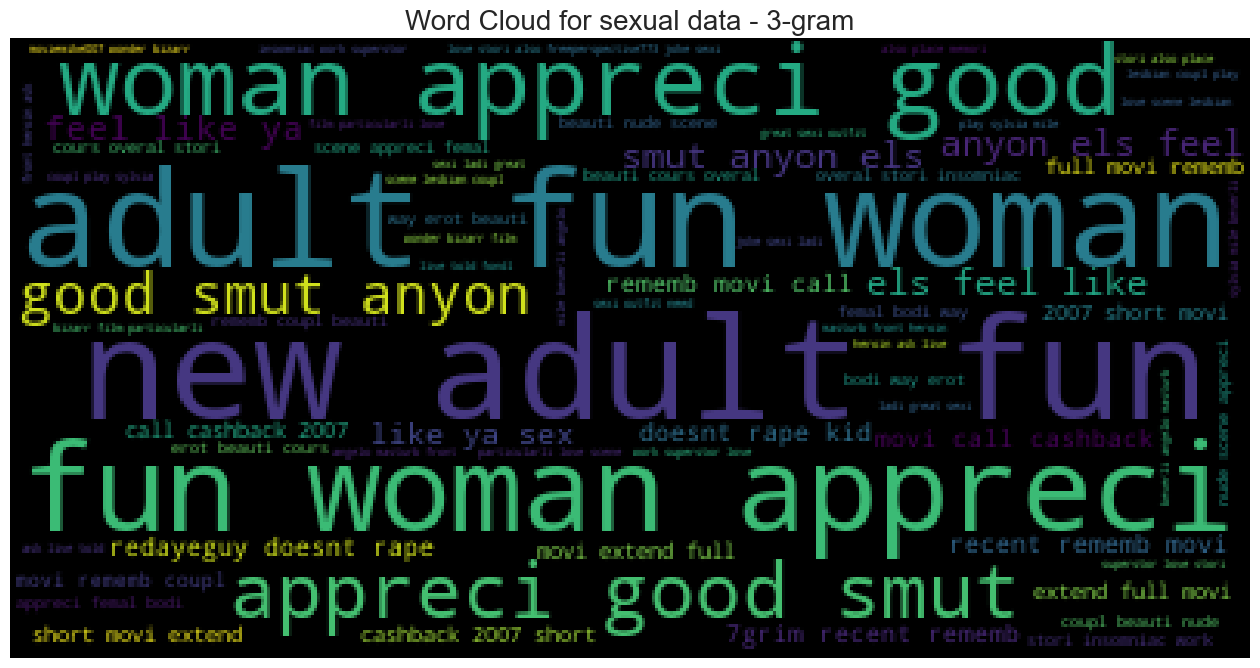

impersonation data
No 1-gram data for impersonation. 

No 2-gram data for impersonation. 

No 3-gram data for impersonation. 

illegal data
illegal data - 1-gram


,Word,Frequency
0,fuck,5
1,pedo,4
2,fix,3
3,beat,3
4,shit,3
5,actual,2
6,like,2
7,around,2
8,still,1
9,guy,1


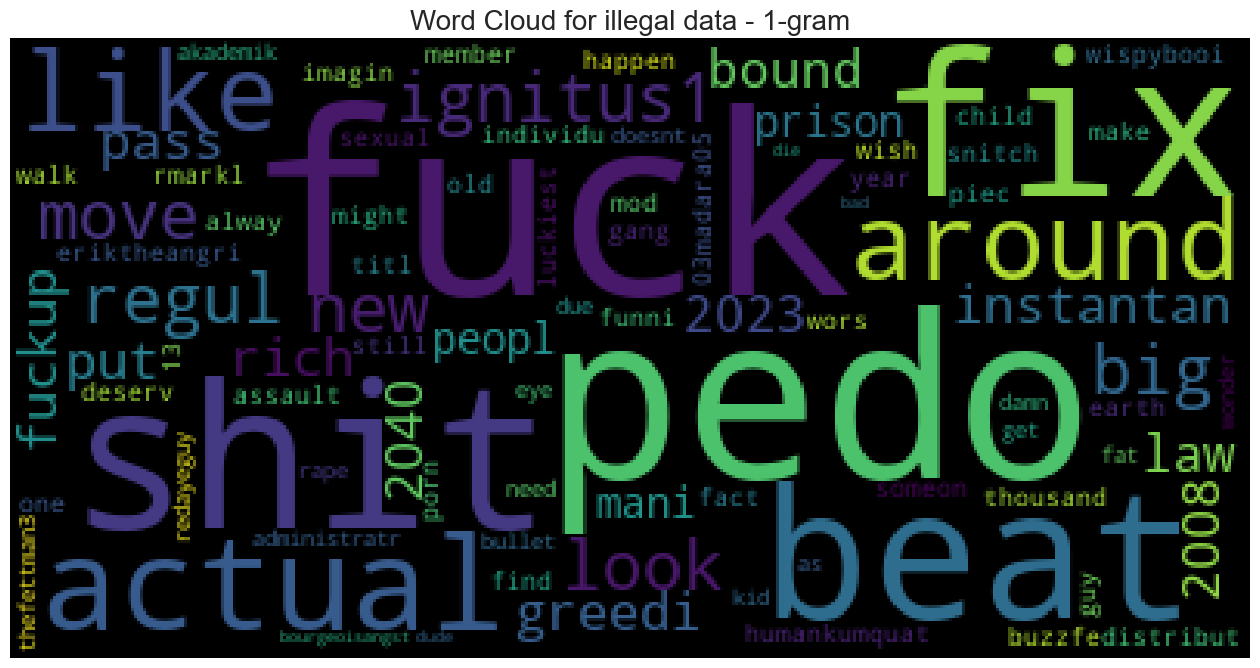

illegal data - 2-gram


,Word,Frequency
0,pedo fuck,2
1,ignitus1 look,1
2,gang member,1
3,might actual,1
4,happen might,1
5,fact happen,1
6,like fact,1
7,around like,1
8,walk around,1
9,still walk,1


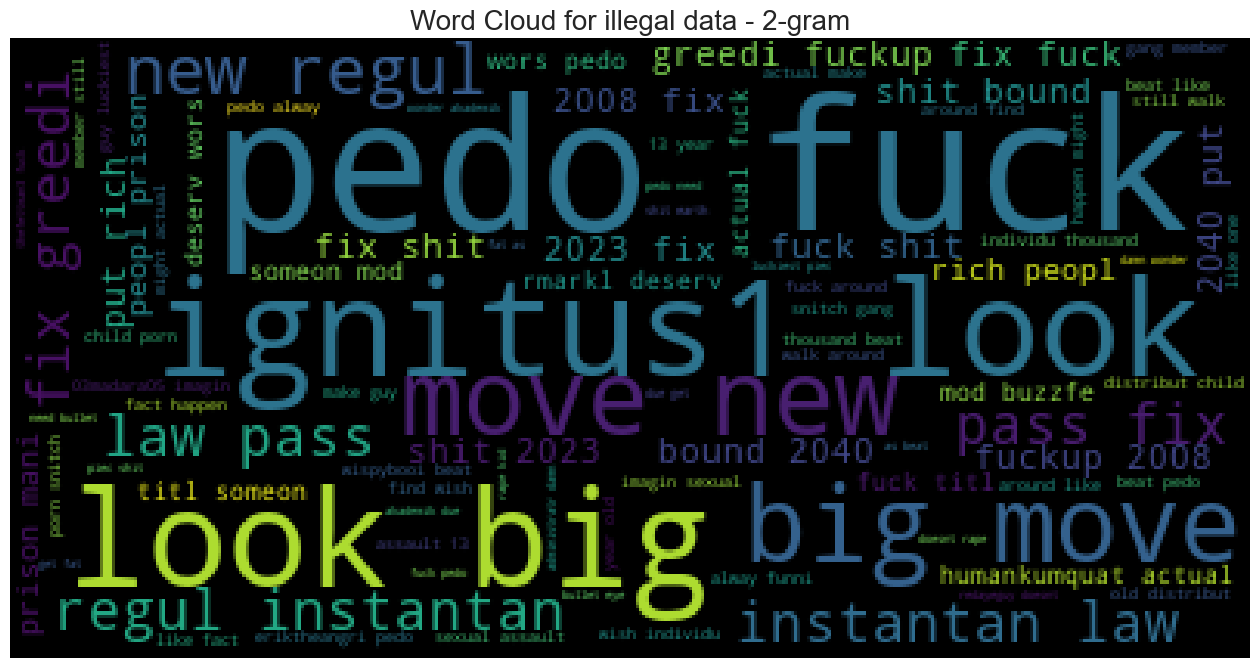

illegal data - 3-gram


,Word,Frequency
0,ignitus1 look big,1
1,porn snitch gang,1
2,fact happen might,1
3,like fact happen,1
4,around like fact,1
5,walk around like,1
6,still walk around,1
7,member still walk,1
8,gang member still,1
9,snitch gang member,1


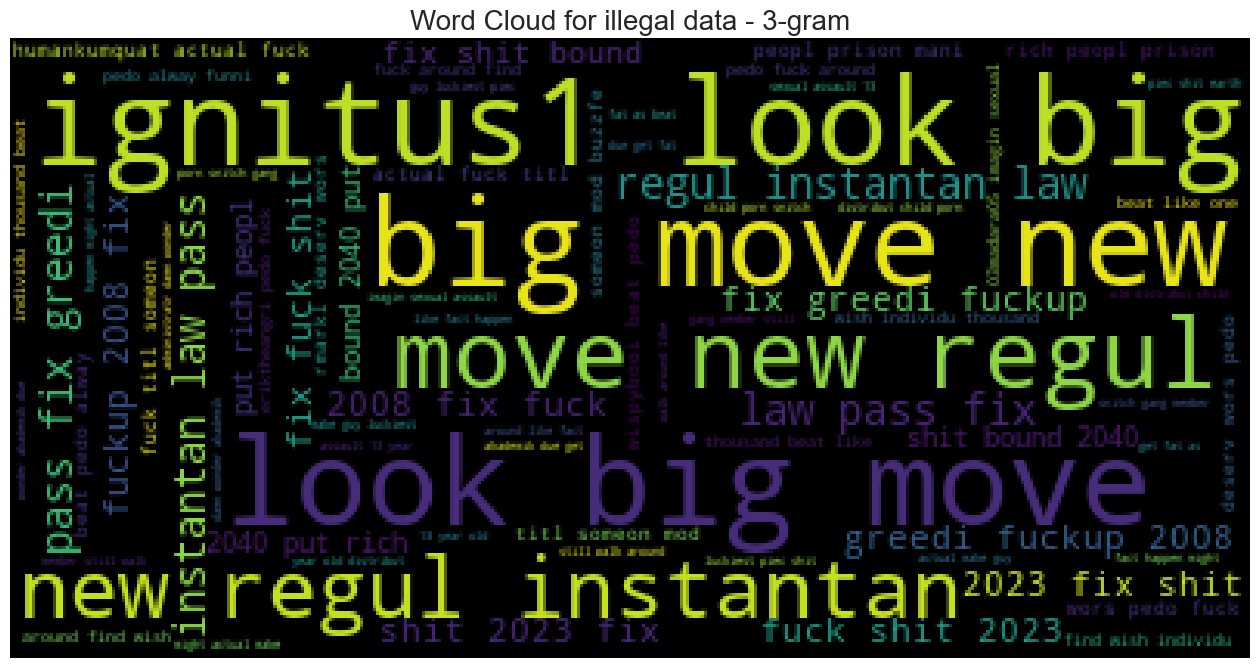

advertisement data
advertisement data - 1-gram


,Word,Frequency
0,x000d,98
1,pandabuy,48
2,ship,42
3,use,41
4,taobao,31
5,career,30
6,agent,30
7,product,27
8,dhl,24
9,time,24


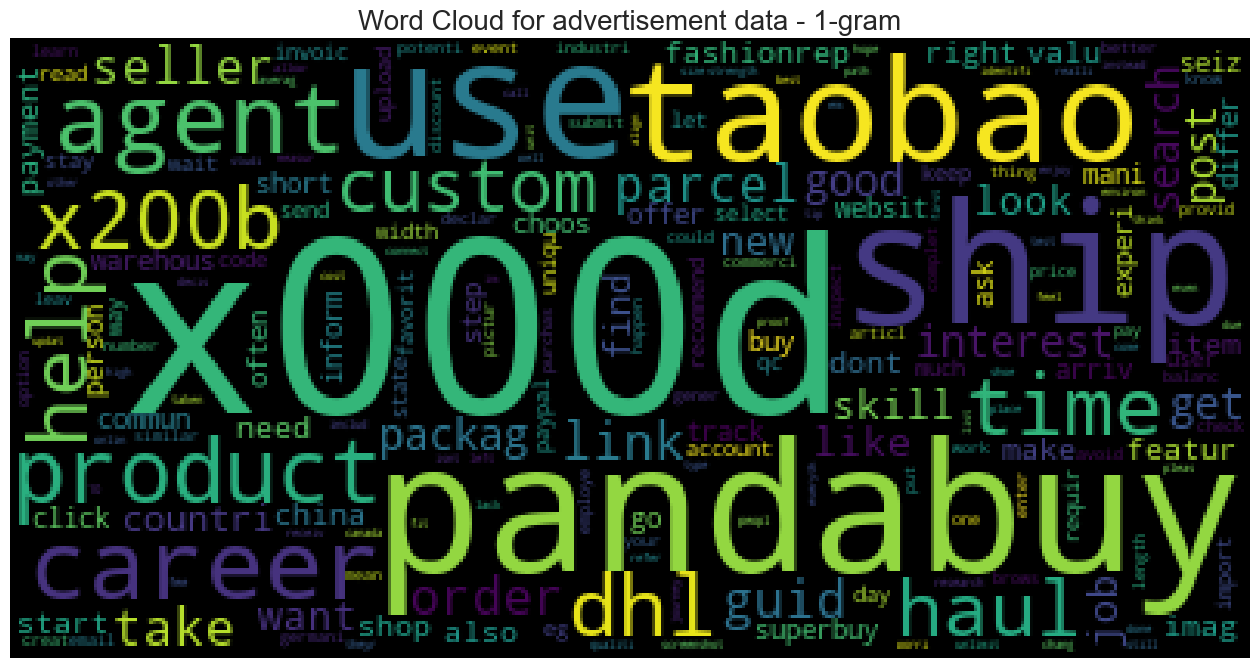

advertisement data - 2-gram


,Word,Frequency
0,commerci invoic,8
1,pandabuy guid,7
2,china post,6
3,potenti career,6
4,often time,6
5,uniqu featur,6
6,taobao agent,5
7,proof payment,5
8,career path,5
9,imag search,5


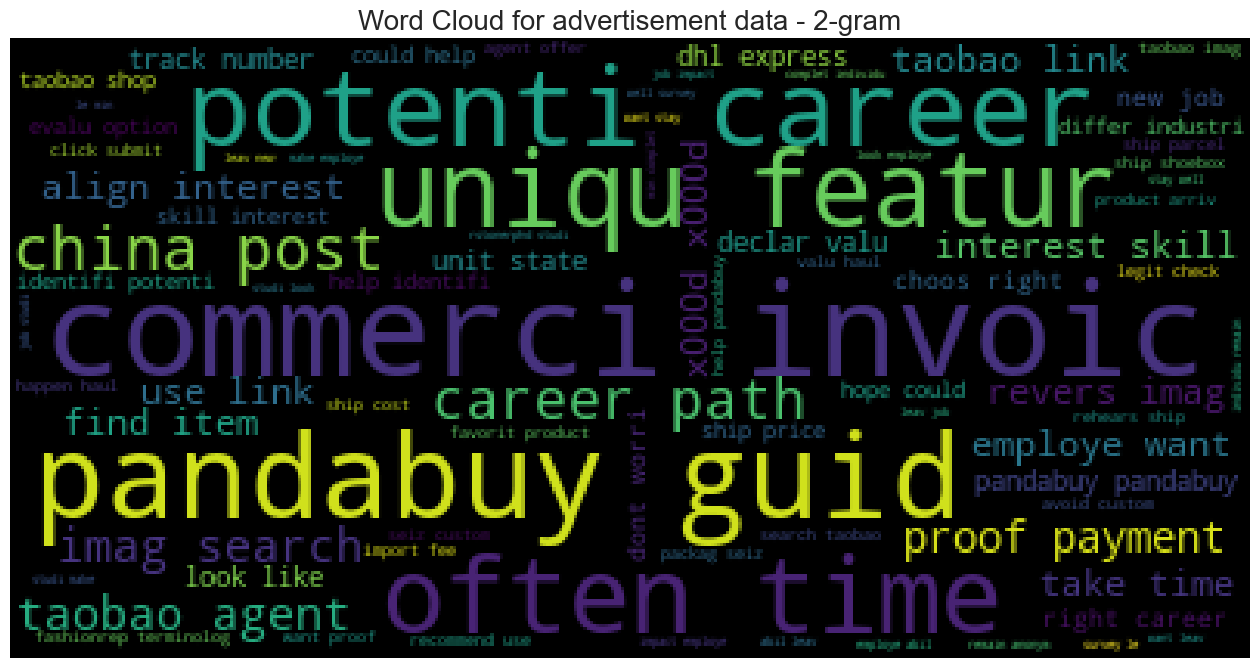

advertisement data - 3-gram


,Word,Frequency
0,revers imag search,4
1,potenti career path,3
2,imag search taobao,3
3,want proof payment,3
4,hope could help,3
5,declar valu haul,3
6,identifi potenti career,3
7,help identifi potenti,3
8,choos right career,3
9,dhl linkhttpswwwdhldeexpressdhl4y fill,2


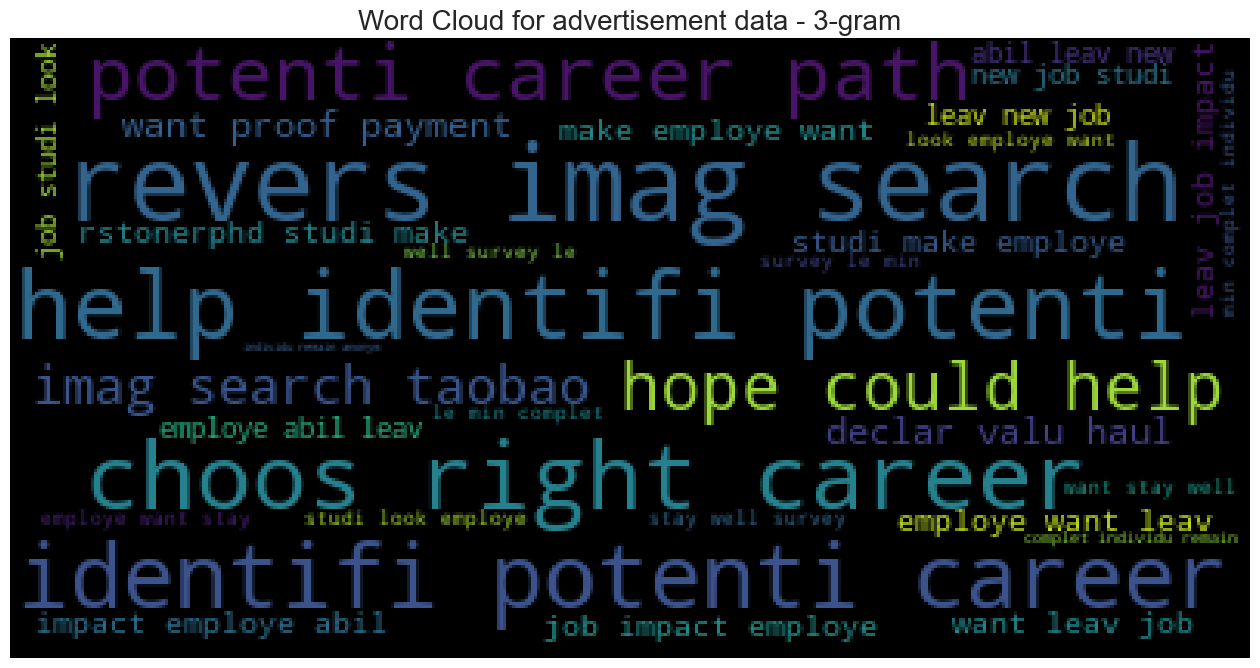

ai data
ai data - 1-gram


,Word,Frequency
0,love,128
1,im,109
2,life,94
3,new,91
4,feel,90
5,favorit,86
6,cant,84
7,make,80
8,time,75
9,way,72


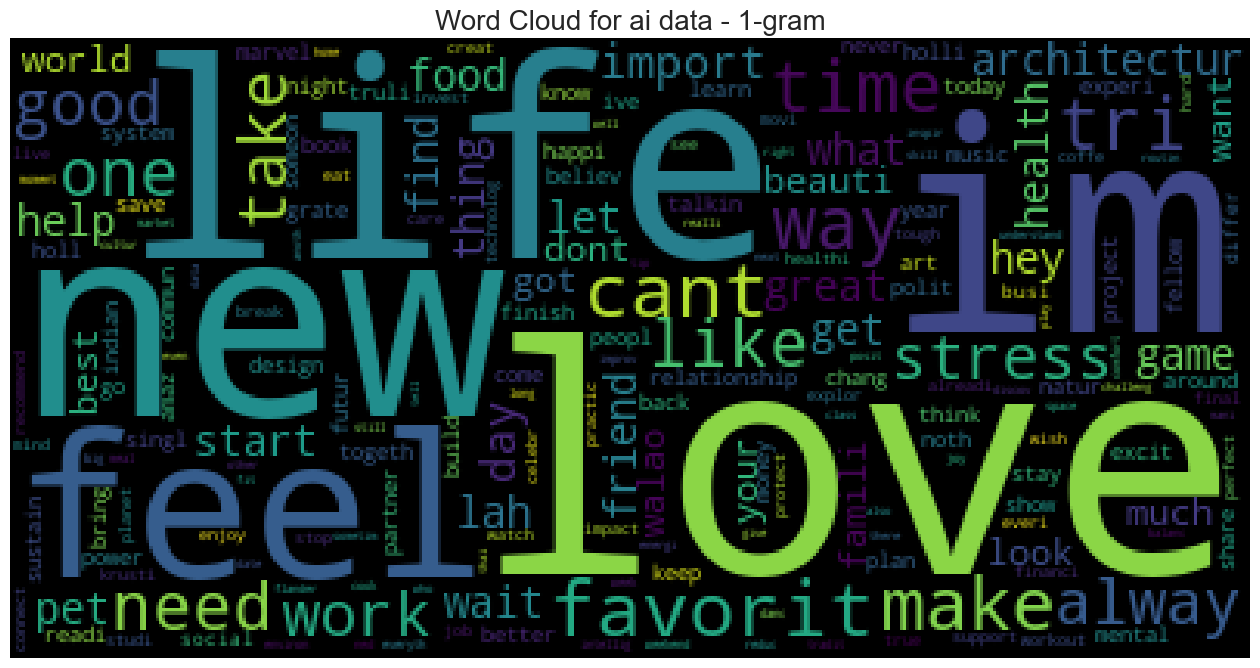

ai data - 2-gram


,Word,Frequency
0,cant wait,32
1,mental health,27
2,tri new,25
3,feel like,24
4,what favorit,22
5,holli holl,22
6,cant believ,17
7,ned flander,15
8,great way,15
9,im alway,14


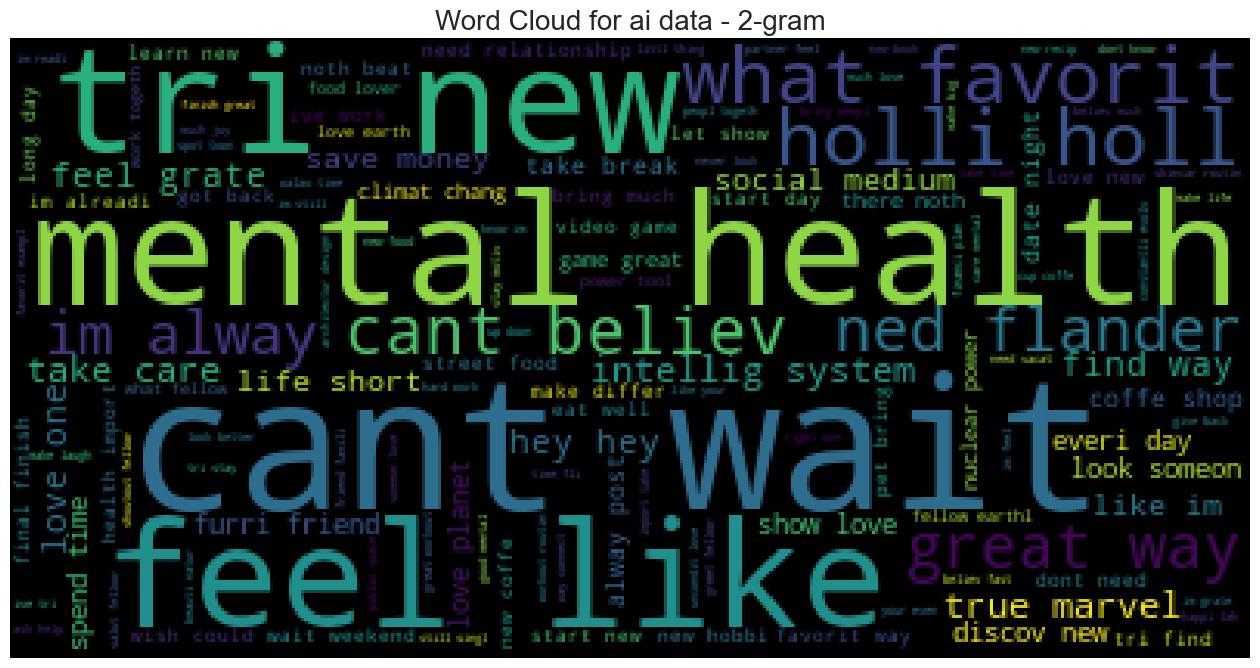

ai data - 3-gram


,Word,Frequency
0,feel like im,9
1,new coffe shop,6
2,tri find way,6
3,cant wait weekend,6
4,game great way,6
5,what favorit way,5
6,bring much joy,4
7,care mental health,4
8,cant believ much,4
9,bring peopl togeth,4


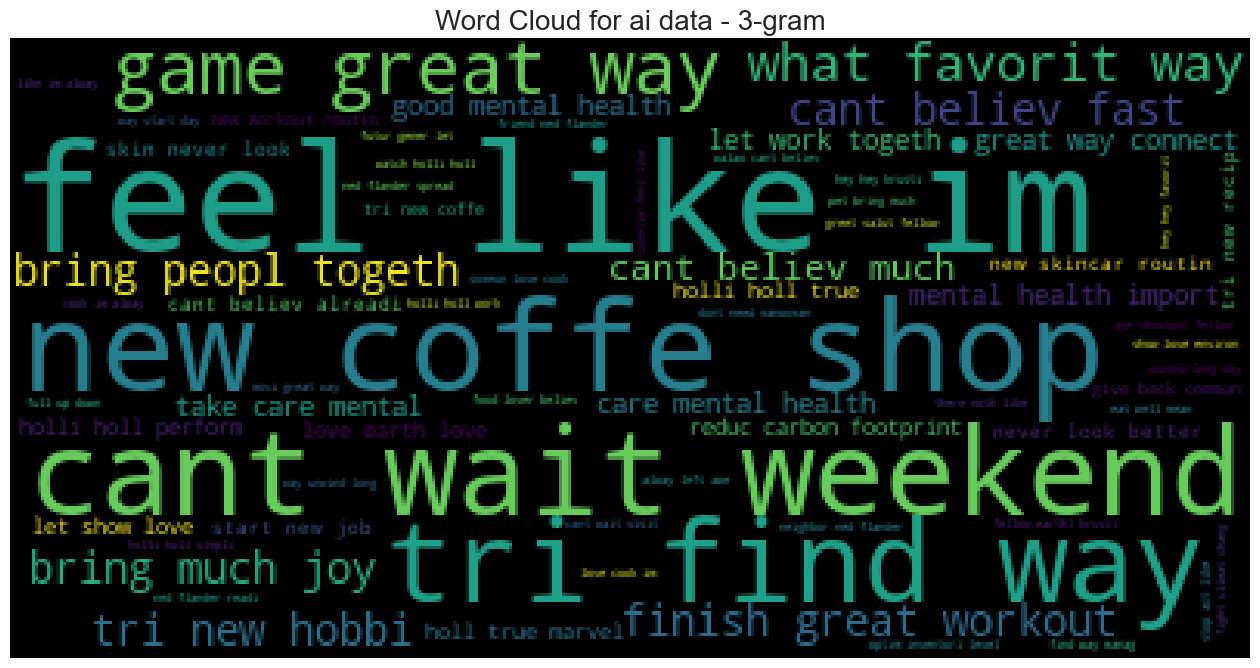

In [132]:
generate_n_gram_analysis(df)